<a href="https://colab.research.google.com/github/sean-halpin/chess_website/blob/models_init/models/Chess_Eval_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Download

In [1]:
# https://database.lichess.org/standard/lichess_db_standard_rated_2013-01.pgn.zst

In [2]:
!pip install zstandard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 26.3 MB/s eta 0:00:00


In [3]:
import requests
import zstandard
import io

lichess = "https://database.lichess.org/standard/"
dbfile = "lichess_db_standard_rated_2017-01.pgn.zst"
url = lichess + dbfile
compressed_file_path = dbfile
output_path = dbfile.replace(".zst","")

# Download the Zstandard compressed file
response = requests.get(url)
if response.status_code == 200:
    with open(compressed_file_path, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully to {compressed_file_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Extract the Zstandard compressed file
with open(compressed_file_path, 'rb') as compressed_file:
    dctx = zstandard.ZstdDecompressor()
    with dctx.stream_reader(compressed_file) as reader:
        with open(output_path, 'wb') as output:
            output.write(reader.read())

print(f"File extracted successfully to {output_path}")


File downloaded successfully to lichess_db_standard_rated_2017-01.pgn.zst
File extracted successfully to lichess_db_standard_rated_2017-01.pgn


# Data Exploration

In [4]:
!ls

lichess_db_standard_rated_2017-01.pgn  lichess_db_standard_rated_2017-01.pgn.zst  sample_data


In [5]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' | wc -l

1235035


In [6]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' | head -n5

1. e4 { [%eval 0.14] } 1... e5 { [%eval 0.16] } 2. Nf3 { [%eval 0.24] } 2... Nc6 { [%eval 0.31] } 3. Bc4 { [%eval 0.15] } 3... Nd4?! { [%eval 0.94] } 4. c3 { [%eval 0.57] } 4... Nxf3+ { [%eval 0.53] } 5. Qxf3 { [%eval 0.52] } 5... Qf6 { [%eval 0.55] } 6. Qe2 { [%eval 0.5] } 6... c6 { [%eval 0.67] } 7. d3 { [%eval 0.37] } 7... Bc5 { [%eval 0.47] } 8. O-O { [%eval 0.16] } 8... Ne7 { [%eval 0.24] } 9. Kh1 { [%eval 0.16] } 9... Ng6 { [%eval 0.17] } 10. g3?! { [%eval -0.71] } 10... O-O?! { [%eval 0.09] } 11. f4?! { [%eval -0.75] } 11... exf4?! { [%eval -0.19] } 12. gxf4?! { [%eval -0.72] } 12... d5 { [%eval -0.64] } 13. exd5? { [%eval -2.46] } 13... cxd5?! { [%eval -1.54] } 14. Bxd5 { [%eval -1.62] } 14... Be6? { [%eval 0.0] } 15. Bxe6 { [%eval -0.03] } 15... fxe6 { [%eval 0.0] } 16. d4 { [%eval 0.0] } 16... Bd6 { [%eval 0.0] } 17. Be3 { [%eval -0.17] } 17... Bxf4 { [%eval -0.08] } 18. Nd2 { [%eval -0.09] } 18... Qf5 { [%eval -0.07] } 19. Nc4?? { [%eval -3.79] } 19... Qd5+ { [%eval -3.64] }

In [7]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' > lichess.pgn.eval

In [8]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.8 MB/s eta 0:00:00


# Data Visualisation

In [ ]:
import chess.pgn
import re

pgn_text = """
1. e4 { [%eval 0.2] [%eval 0.2] } 1... e6 { [%eval 0.13] } 2. Bc4 { [%eval -0.31] } 2... d5 { [%eval -0.28] } 3. exd5 { [%eval -0.37] } 3... exd5 { [%eval -0.31] } 4. Bb3 { [%eval -0.33] } 4... Nf6 { [%eval -0.35] } 5. d4 { [%eval -0.34] } 5... Be7 { [%eval 0.0] } 6. Nf3 { [%eval 0.0] } 6... O-O { [%eval -0.08] } 7. Bg5 { [%eval -0.19] } 7... h6 { [%eval -0.29] } 8. Bxf6 { [%eval -0.36] } 8... Bxf6 { [%eval -0.37] } 9. O-O { [%eval -0.36] } 9... c6 { [%eval -0.12] } 10. Re1 { [%eval -0.17] } 10... Bf5 { [%eval -0.04] } 11. c4?! { [%eval -0.67] } 11... dxc4 { [%eval -0.5] } 12. Bxc4 { [%eval -0.77] } 12... Nd7?! { [%eval -0.1] } 13. Nc3 { [%eval 0.0] } 13... Nb6 { [%eval 0.0] } 14. b3?! { [%eval -0.76] } 14... Nxc4 { [%eval -0.49] } 15. bxc4 { [%eval -0.65] } 15... Qa5 { [%eval -0.55] } 16. Rc1 { [%eval -0.79] } 16... Rad8 { [%eval -0.78] } 17. d5?? { [%eval -5.41] } 17... Bxc3 { [%eval -5.42] } 18. Re5? { [%eval -7.61] } 18... Bxe5 { [%eval -7.78] } 19. Nxe5 { [%eval -7.72] } 19... cxd5 { [%eval -7.81] } 20. Qe1? { [%eval -9.29] } 20... Be6?? { [%eval 3.71] } 21. Rd1?? { [%eval -12.34] } 21... dxc4 { [%eval -12.71] } 22. Rxd8?! { [%eval #-1] } 22... Rxd8?! { [%eval -13.06] } 23. Qc3?! { [%eval #-2] } 23... Qxc3?! { [%eval #-4] } 24. g3 { [%eval #-3] } 24... Rd1+?! { [%eval #-4] } 25. Kg2 { [%eval #-4] } 25... Qe1?! { [%eval #-4] } 26. Kf3 { [%eval #-3] } 26... Qxe5 { [%eval #-2] } 27. Kg2 { [%eval #-2] } 27... Bd5+?! { [%eval #-2] } 28. Kh3 { [%eval #-1] } 28... Qh5# 0-1
"""

game = chess.pgn.read_game(io.StringIO(pgn_text))

board = game.board()
for node in list(game.mainline()):
    print()
    print(node.move)
    # print(node)
    print(node.comment)
    pattern = r"\[%eval\s+([#])*([\d.-]+)\]"
    match = re.search(pattern, node.comment)
    if match:
        print((match.group(1) if match.group(1) is not None else ""), match.group(2))
    else:
        print("No '%eval' found in the text.")
    board.push(node.move)
    print(board)
    checkMate = board.is_checkmate()
    print("Checkmate?", checkMate)
    i=0
    for square in chess.SQUARES:
      piece = board.piece_at(square)
      print(f"Square {chess.square_name(square)}: {piece}: {piece.piece_type if piece is not None else 0}")


In [28]:
import pandas as pd
rows_data = []
columns = []
for square in chess.SQUARES:
  piece = board.piece_at(square)
  columns.append(chess.square_name(square))
columns.append("eval")
columns.append("check_in")

i=0
with open('lichess.pgn.eval', 'r') as file:
    for pgn_text in file:
      # print(pgn_text)
      game = chess.pgn.read_game(io.StringIO(pgn_text))
      board = game.board()
      for node in list(game.mainline()):
          row_data = [(((board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1))) if board.piece_at(square) is not None else 0) for square in chess.SQUARES]
          pattern = r"\[%eval\s+([#])*([\d.-]+)\]"
          match = re.search(pattern, node.comment)
          if match:
            if match.group(1) is None:
              eval = f"{match.group(2)}"
              check_in = 0 #Integer.MAX_VALUE if board.piece_at(square).color else Integer.MIN_VALUE
            else:
              eval = 0
              check_in = f"{match.group(2)}"
          row_data.append(eval)
          row_data.append(check_in)
          rows_data.append(row_data)
          # move next
          board.push(node.move)
      i+=1
      if i % 1_000 == 0:
        print(i)
      if i >= 10_000:
        break

df = pd.DataFrame(rows_data, columns=columns)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [29]:
df

,a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,...,a8,b8,c8,d8,e8,f8,g8,h8,eval,check_in
0,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.14,0
1,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.16,0
2,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.24,0
3,4,2,3,5,6,3,0,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.31,0
4,4,2,3,5,6,3,0,4,1,1,...,-4,0,-3,-5,-6,-3,-2,-4,0.15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629195,4,0,0,5,6,3,0,4,1,1,...,0,-4,-3,-5,-6,0,0,-4,0.71,0
629196,4,0,0,5,6,3,0,4,1,1,...,0,-4,-3,-5,-6,0,0,-4,0,2
629197,4,0,0,5,6,3,0,4,1,1,...,0,-4,-3,-5,-6,0,0,-4,0,1
629198,4,0,0,0,6,3,0,4,1,1,...,0,-4,-3,-5,-6,0,0,-4,0,1


In [30]:
df.dtypes

a1           int64
b1           int64
c1           int64
d1           int64
e1           int64
             ...  
f8           int64
g8           int64
h8           int64
eval        object
check_in    object
Length: 66, dtype: object

In [31]:
df['eval'] = df['eval'].astype(float)
df['check_in'] = df['check_in'].astype(float)

# Define Model

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3_eval = nn.Linear(128, 1)  # Output for 'eval'
        self.fc3_check_in = nn.Linear(128, 1)  # Output for 'check_in'

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        eval_output = self.fc3_eval(x)
        check_in_output = self.fc3_check_in(x)
        return eval_output, check_in_output


In [40]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the data
X = df.drop(columns=['eval', 'check_in']).values
y = df[['eval', 'check_in']].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model and move it to GPU if available
input_dim = X_train.shape[1]
model = Net(input_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    eval_output, check_in_output = model(X_train_tensor)

    # Compute the loss for 'eval' output
    eval_loss = criterion(eval_output, y_train_tensor[:, 0].view(-1, 1))  # Assuming 'eval' is the first column

    # Compute the loss for 'check_in' output
    check_in_loss = criterion(check_in_output, y_train_tensor[:, 1].view(-1, 1))  # Assuming 'check_in' is the second column

    # Combine the losses (e.g., by summing)
    loss = eval_loss + check_in_loss

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    eval_output, check_in_output = model(X_test_tensor)

    # Compute the loss for 'eval' output
    eval_loss = criterion(eval_output, y_test_tensor[:, 0].view(-1, 1))  # Assuming 'eval' is the first column

    # Compute the loss for 'check_in' output
    check_in_loss = criterion(check_in_output, y_test_tensor[:, 1].view(-1, 1))  # Assuming 'check_in' is the second column

    # Combine the losses (e.g., by summing)
    test_loss = eval_loss + check_in_loss

    print(f'Test Loss: {test_loss.item()}')


Epoch 1/1000, Loss: 78.45681762695312
Epoch 11/1000, Loss: 77.132080078125
Epoch 21/1000, Loss: 74.26972198486328
Epoch 31/1000, Loss: 70.16387176513672
Epoch 41/1000, Loss: 66.0151138305664
Epoch 51/1000, Loss: 64.02619171142578
Epoch 61/1000, Loss: 63.1136474609375
Epoch 71/1000, Loss: 62.4844970703125
Epoch 81/1000, Loss: 62.024322509765625
Epoch 91/1000, Loss: 61.65997314453125
Epoch 101/1000, Loss: 61.34531021118164
Epoch 111/1000, Loss: 61.06633758544922
Epoch 121/1000, Loss: 60.812374114990234
Epoch 131/1000, Loss: 60.574642181396484
Epoch 141/1000, Loss: 60.347900390625
Epoch 151/1000, Loss: 60.12519454956055
Epoch 161/1000, Loss: 59.90372848510742
Epoch 171/1000, Loss: 59.69664764404297
Epoch 181/1000, Loss: 59.485496520996094
Epoch 191/1000, Loss: 59.26762390136719
Epoch 201/1000, Loss: 59.03563690185547
Epoch 211/1000, Loss: 58.79666519165039
Epoch 221/1000, Loss: 58.571014404296875
Epoch 231/1000, Loss: 58.30270767211914
Epoch 241/1000, Loss: 58.03506851196289
Epoch 251/100

# Play Chess

In [41]:
def generate_pgn(board, moves):
    game = chess.pgn.Game()

    node = game
    for move in moves:
        node = node.add_variation(move)

    game.headers["Result"] = board.result()
    return str(game)

********************************* 



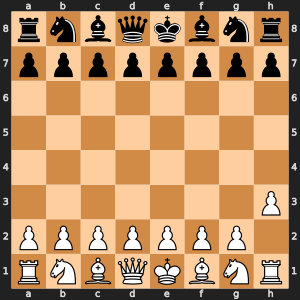

********************************* 



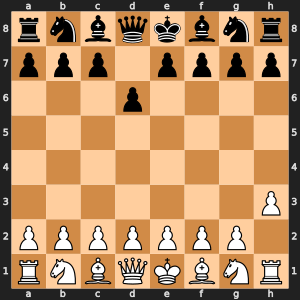

********************************* 



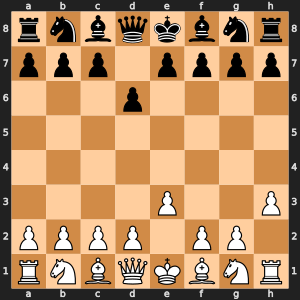

********************************* 



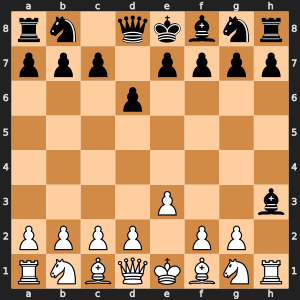

********************************* 



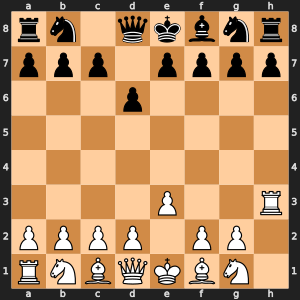

********************************* 



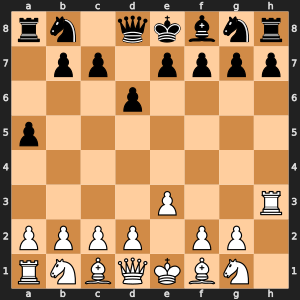

********************************* 



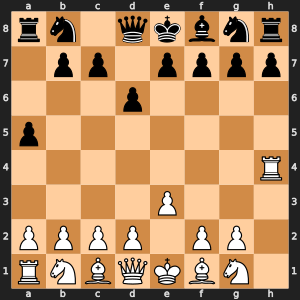

********************************* 



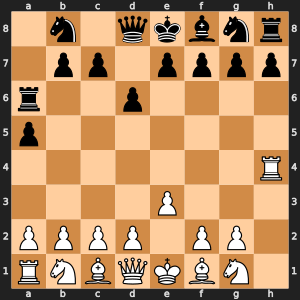

********************************* 



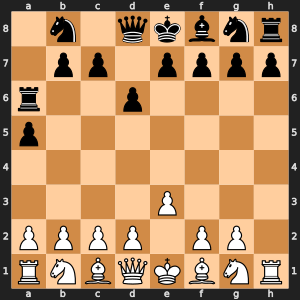

********************************* 



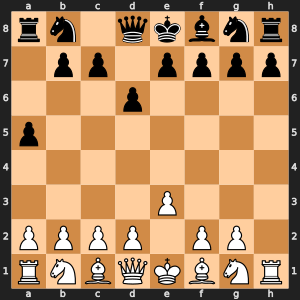

********************************* 



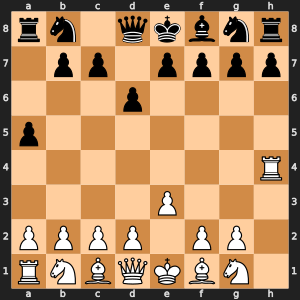

********************************* 



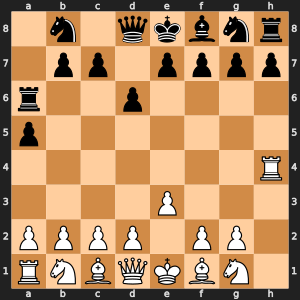

********************************* 



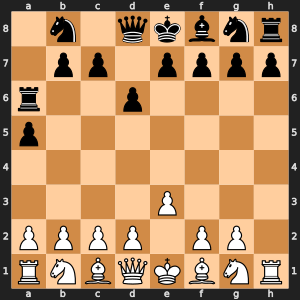

********************************* 



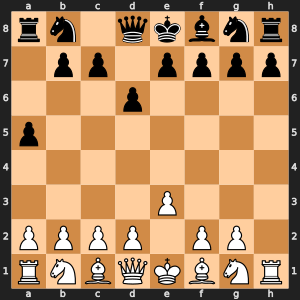

********************************* 



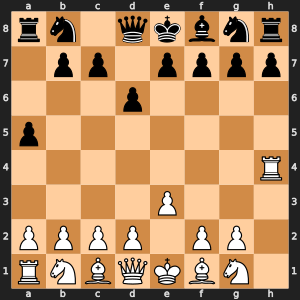

********************************* 



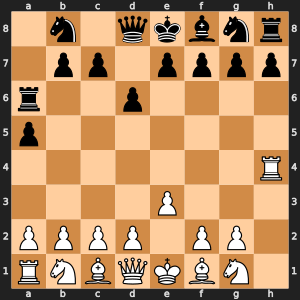

********************************* 



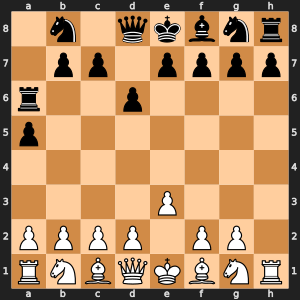

********************************* 



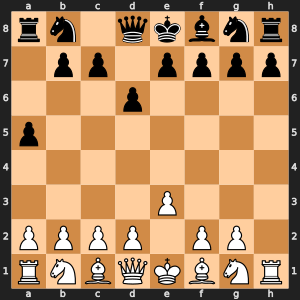

********************************* 



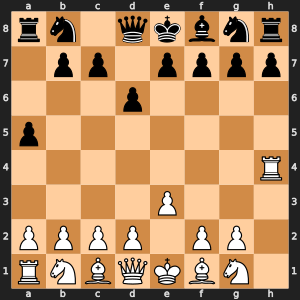

********************************* 



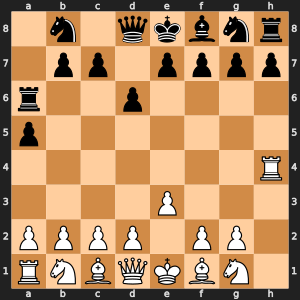

********************************* 



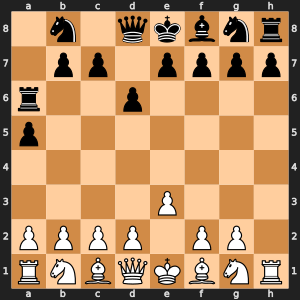

********************************* 



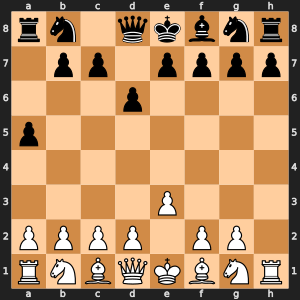

********************************* 



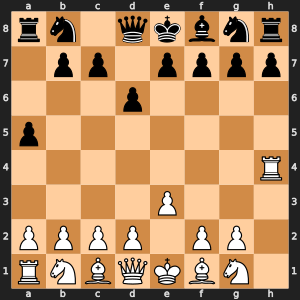

********************************* 



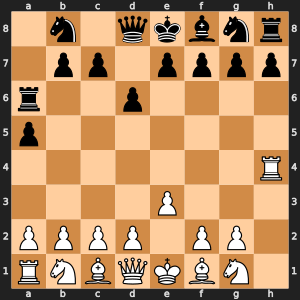

Game Over
Result:  1/2-1/2
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "1/2-1/2"]

1. h3 d6 2. e3 Bxh3 3. Rxh3 a5 4. Rh4 Ra6 5. Rh1 Ra8 6. Rh4 Ra6 7. Rh1 Ra8 8. Rh4 Ra6 9. Rh1 Ra8 10. Rh4 Ra6 11. Rh1 Ra8 12. Rh4 Ra6 1/2-1/2


In [44]:
import chess
import chess.svg
import torch
import torch.nn as nn
from IPython.display import SVG, display

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a function to convert the board state into a format suitable for input to the neural network
def preprocess_board_state(board):
    board_state = [(((board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1))) if board.piece_at(square) is not None else 0) for square in chess.SQUARES]
    return torch.tensor(board_state, dtype=torch.float32).to(device)

# Define a function to generate legal moves for the current player
def generate_legal_moves(board):
    legal_moves = []
    for move in board.legal_moves:
        legal_moves.append(move)
    return legal_moves

# Evaluate each legal move using the neural network model and select the move with the highest evaluation
def select_best_move(board, legal_moves, model):
    whitePlays = board.turn
    best_move = None
    best_eval = float('-inf') if board.turn else float('inf')  # Initialize best evaluation based on player's perspective

    for move in legal_moves:
        board.push(move)
        board_state = preprocess_board_state(board)
        eval_output, _ = model(board_state)

        # Assuming 'eval_output' contains the evaluation for the current player's perspective
        eval_value = eval_output.item()

        if whitePlays:  # Maximizing player
            if eval_value > best_eval:
                best_eval = eval_value
                best_move = move
        else:  # Minimizing player
            if eval_value < best_eval:
                best_eval = eval_value
                best_move = move

        board.pop()

    return best_move

# Play a game of chess using the model
def play_game(model):
    board = chess.Board()
    moves = []
    while not board.is_game_over():
        if board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.is_seventyfive_moves():
            print("Game Over")
            print("Result: ", board.result())
            return

        legal_moves = generate_legal_moves(board)
        if len(legal_moves) == 0:
            print("Game Over - No legal moves left")
            print("Result: ", board.result())
            return

        best_move = select_best_move(board, legal_moves, model)
        board.push(best_move)
        moves.append(best_move)
        print("*********************************", "\n")
        display(SVG(chess.svg.board(board,size=300)))

    # Print the final result of the game
    print("Game Over")
    print("Result: ", board.result())
    print(generate_pgn(board, moves))  # Generate and print the PGN

# Example usage:
# Assuming 'model' is your trained neural network model
play_game(model.to(device))  # Move the model to GPU if available


In [45]:
print(board)

. r b q . k . r
p p . . b Q . .
. . p . p p . p
. . . p N . p .
. . P P . . . .
. . N . P . . .
P P . . . P P P
R . . . K B . R
